In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import gensim    ## Word Embeddings

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Read the file containing cleaned reviews

In [2]:
conn = sqlite3.connect('../8. Amazon_New/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()

In [3]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


### Read the list_of_sent created during EDA and cleaning

In [3]:
with open('../8. Amazon_New/list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

### Recall below is the first element of list_of_sent

In [6]:
print(list_of_sent[0])

['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


#### Training the Word2Vec model for words with min count 5¶
Reference for intuition - https://www.tensorflow.org/tutorials/word2vec

In [37]:
## size is the no of dimensions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=-1)

In [38]:
# Check the number of unique words in the vocabulary
words = list(w2v_model.wv.vocab)
print(len(words))

23157


**Intuitive understanding of W2V - Check the most similar words to a given word**

In [40]:
w2v_model.wv.most_similar('tasti')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('zaatar', 0.5735179781913757),
 ('bough', 0.526114821434021),
 ('shoebox', 0.5048079490661621),
 ('mallomar', 0.5015389919281006),
 ('visit', 0.4882321059703827),
 ('simplic', 0.485422819852829),
 ('mortal', 0.4739305377006531),
 ('papadum', 0.469342440366745),
 ('wiht', 0.4687284827232361),
 ('173', 0.4659099876880646)]

In [41]:
w2v_model.wv.most_similar('like')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dissappear', 0.5243841409683228),
 ('spendi', 0.5138816237449646),
 ('whiten', 0.5043807625770569),
 ('landscap', 0.4846740961074829),
 ('offer', 0.4844324588775635),
 ('mambo', 0.47599223256111145),
 ('worker', 0.47495415806770325),
 ('rustl', 0.4710223078727722),
 ('nelson', 0.4708782434463501),
 ('ultrasound', 0.4671080410480499)]

## Function to calculate Avg Word2Vec

In [42]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        ## Note: Size of the vector must match the no. of dimensions used in word2vec model
        sent_vec = np.zeros(50)
        
        ## Initialize count of words to 0
        cnt_words = 0
        
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [43]:
start = time.time()
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)
end = time.time()
print("Time taken in minutes", (end - start)/60)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time taken in minutes 6.152189866701762


In [45]:
len(sent_vectors), len(sent_vectors[0])

(363857, 50)

In [49]:
# example dense vector
print(sent_vectors[1020])

[-1.58500453e-03  1.25931394e-03  4.81601389e-04 -9.56613550e-06
  1.55688269e-03  2.75262945e-03 -1.34308745e-03 -5.70898271e-04
  6.09443725e-04  1.03349863e-03 -9.52538833e-04 -2.72247703e-03
  3.41567257e-04 -1.89997194e-03  2.09309676e-03 -1.51114208e-04
  2.49414284e-03 -1.02259666e-03  1.27831668e-03  4.60717491e-04
 -1.98890812e-03  1.08601094e-03 -7.16831495e-05 -1.16856771e-03
 -7.13653390e-04 -9.44401887e-05  5.36268612e-04 -4.35571672e-03
 -1.25983414e-03 -3.89494321e-04  1.25650382e-03  1.39477127e-03
  1.48109324e-04 -9.37922982e-04 -6.62678473e-04 -1.27830607e-03
  8.28539406e-04 -2.00479674e-04  1.37106146e-03 -1.18693757e-03
  2.60284378e-04  1.54206403e-03  1.85470340e-03  4.83643369e-04
 -1.69119677e-03 -4.82099179e-04  9.60774836e-04 -1.92392629e-03
  3.91276204e-04  1.71157562e-04]


### Convert the list of vectors into a pandas dataframe

In [50]:
df = pd.DataFrame(sent_vectors)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000994,-0.001200,-0.000592,-0.000332,0.003839,-0.001236,0.000538,-0.001063,0.002179,-0.001249,...,-0.001743,0.000168,0.001167,0.000839,0.000871,0.000069,0.000134,0.001042,-0.000939,-0.000515
1,-0.001138,-0.000662,0.001932,-0.000279,-0.000166,-0.002701,0.000978,0.001006,-0.002395,0.002002,...,-0.000377,0.005525,0.000948,0.000652,0.002871,-0.000345,0.001333,-0.001796,-0.002315,0.000613
2,0.000414,0.000209,0.000418,0.000901,-0.000594,-0.001485,-0.001612,-0.000216,0.000177,-0.000575,...,0.000445,-0.000955,0.000514,-0.001139,0.000266,-0.000551,0.001802,-0.000096,-0.000671,0.000893
3,-0.002251,-0.000310,0.000445,0.000662,-0.000651,0.001942,-0.001938,-0.000942,0.001570,-0.001456,...,-0.000459,-0.001013,-0.001923,0.000565,-0.000134,0.000879,0.001011,0.000470,-0.001482,0.000077
4,0.004403,0.000178,-0.000167,-0.000287,0.000547,-0.001411,-0.002509,-0.000469,-0.001253,0.000793,...,0.000227,-0.000348,-0.000671,-0.002184,-0.002110,-0.002388,-0.002377,-0.003431,-0.001461,0.003446


### Add the Time and Score columns to the dataframe

In [51]:
df = pd.concat([final['Time'], final['Score'], df], axis = 1)
df.head()

,Time,Score,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,1303862400,1,0.000994,-0.001200,-0.000592,-0.000332,0.003839,-0.001236,0.000538,-0.001063,...,-0.001743,0.000168,0.001167,0.000839,0.000871,0.000069,0.000134,0.001042,-0.000939,-0.000515
1,1346976000,0,-0.001138,-0.000662,0.001932,-0.000279,-0.000166,-0.002701,0.000978,0.001006,...,-0.000377,0.005525,0.000948,0.000652,0.002871,-0.000345,0.001333,-0.001796,-0.002315,0.000613
2,1219017600,1,0.000414,0.000209,0.000418,0.000901,-0.000594,-0.001485,-0.001612,-0.000216,...,0.000445,-0.000955,0.000514,-0.001139,0.000266,-0.000551,0.001802,-0.000096,-0.000671,0.000893
3,1307923200,0,-0.002251,-0.000310,0.000445,0.000662,-0.000651,0.001942,-0.001938,-0.000942,...,-0.000459,-0.001013,-0.001923,0.000565,-0.000134,0.000879,0.001011,0.000470,-0.001482,0.000077
4,1350777600,1,0.004403,0.000178,-0.000167,-0.000287,0.000547,-0.001411,-0.002509,-0.000469,...,0.000227,-0.000348,-0.000671,-0.002184,-0.002110,-0.002388,-0.002377,-0.003431,-0.001461,0.003446


#### Since KNN is a bit slow and requires more RAM, we will use a sample of the dataset.
Since we are sampling the dataset, we will create a balanced dataset containing only 10000 points (5000 positive and 5000 negative)

In [52]:
negative = df[df['Score'] == 0]
positive = df[df['Score'] == 1]
data = pd.concat([negative.iloc[:5000,:], positive.iloc[:5000,:]], axis = 0, ignore_index = True)
## Sort the dataframe on time
data.sort_values('Time', inplace = True)
data.head()

,Time,Score,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
5954,961718400,1,-0.000271,-0.001503,0.001929,-0.000523,0.002598,-0.001261,-0.004744,-0.000404,...,-0.002476,0.000521,0.002572,0.001378,0.000661,0.000855,0.000592,0.000404,-0.001087,0.001004
5953,962236800,1,0.000151,0.000419,0.000420,-0.000511,0.000588,-0.001145,-0.001344,-0.000874,...,-0.000304,-0.001158,-0.000023,-0.000308,0.000162,-0.000308,-0.000163,-0.000058,-0.000770,-0.000090
7890,1081555200,1,-0.000147,-0.001155,0.000378,0.000422,-0.000351,0.000470,0.000872,-0.000895,...,0.001579,-0.000505,-0.002012,0.000521,0.001186,-0.001819,-0.001764,0.002542,0.001200,-0.002213
4650,1084665600,0,-0.000367,0.002989,-0.002085,0.001635,0.004074,0.002553,0.004995,0.000728,...,0.000842,0.000502,-0.003619,-0.000025,0.001170,0.002789,0.004420,0.003658,-0.002678,0.000975
5924,1088467200,1,0.001358,-0.000464,0.000290,-0.000722,0.000932,-0.001236,-0.000472,0.000461,...,0.000872,-0.000452,-0.000292,-0.001623,-0.000610,-0.000658,-0.000297,0.000566,-0.000280,-0.000117


In [53]:
data.shape

(10000, 52)

In [71]:
# If you do not require some variables, delete them from your main memory
del final, df, negative, positive

In [54]:
data['Score'].value_counts()

1    5000
0    5000
Name: Score, dtype: int64

### Separate the featues fom the target variable

In [57]:
X = data.drop(labels=['Time', 'Score'], axis = 1)
y = data['Score']

### Train Test Split

In [62]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 50), (7000,), (3000, 50), (3000,))

### Column Standardization

In [64]:
# Create an object of StandardScaler
s = StandardScaler() # Since we are passing sparse matrix
# Call the fit_transform method on training data
X_train = s.fit_transform(X_train)
# Call the transform method on the test dataset
X_test = s.transform(X_test)

## Model Building - Hyperparameter tuning and k-fold Cross validation

In [65]:
start = time.time()
# creating odd list of K for KNN
neighbors = range(1,20,2)

cv_scores = [] # empty list that will hold cv scores

# Try each value of k in the below loop
for k in neighbors:
    # Create an object of the class KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 4 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_k = neighbors[cv_error.index(min(cv_error))]
print('\nThe optimal number of neighbors is', optimal_k)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal number of neighbors is 17
Total time in minutes =  3.1074315667152406


Text(0,0.5,'Misclassification Error')

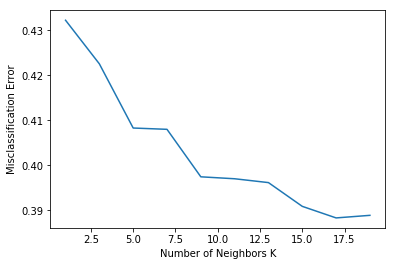

In [66]:
# plot misclassification error vs k 
plt.plot(neighbors, cv_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

### Build the final model with the optimal value of k

In [67]:
clf = KNeighborsClassifier(n_neighbors = optimal_k)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

### Make the predictions on the test set

In [68]:
y_pred = clf.predict(X_test)

### Calculate test accuracy

In [69]:
acc = accuracy_score(y_test, y_pred) * 100
acc

60.66666666666667

### Check the confusion matrix

In [70]:
confusion_matrix(y_test, y_pred)

array([[1011,  572],
       [ 608,  809]], dtype=int64)

#### Refer - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
**Interpretation:**
* 1011 negative reviews classified as negative (true negative)
* 572 positive reviews classified as negative (false negative)
* 608 negative reviews classified as positive (false positive)
* 809 positive reviews classified as positive (true positive)

### Predict Probabilities

In [ ]:
# Select a random test point
i = np.random.randint(1,3000)
y_pred = clf.predict(X_test[i])[0]
y_proba = clf.predict_proba(X_test[i])[0]
print("Actual class:",y_test.iloc[i])
print("Predicted class class:",y_pred)
print("Predicted probabilities",y_proba)